# Analyzing NYTbd Sample 4
<br>
This notebook is looking at the NYTbd Sample 4 content analyzed by ACCENT and PETRARCH2 to identify current limitations with PETRARCH2 and to try and devise solutions. 

In [1]:
# Setup Environment
from nltk.parse.corenlp import CoreNLPServer
from nltk.parse.corenlp import CoreNLPDependencyParser
from nltk.parse import CoreNLPParser

import pandas as pd

import pprint
import nltk

from nltk.tree import *
from IPython.display import display

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Link to Java Server for Standford CoreNLP
<br>
java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -annotators "tokenize,ssplit,pos,lemma,parse,sentiment" -port 9000 -timeout 100000

In [2]:
# Connect to Server
parser = CoreNLPParser('http://localhost:9000')
depr = CoreNLPDependencyParser('http://localhost:9000')

#### Write Some Functions for Parsing Text

In [3]:
# Core Parser- save as df['parsed']
def core_parser(df, col):
    parse = []
    i = ""
    for i in range(len(df)):
        parse.append(i)
        parse[i] = next(parser.raw_parse(df[col].iloc[i]))
    return parse

# Dependency Parser- save as df['dep']
def dep_parser(df, col):
    dep = []
    i = ""
    for i in range(len(df)):
        dep.append(i)
        dep[i] = next(depr.raw_parse(df[col].iloc[i]))
    return dep

# For easy display of both parse trees, text, and code
def easy_read(corp, index_num):
    display(corp['parsed'].iloc[index_num])
    display(corp['dep'].iloc[index_num])
    display("Text = " + corp.iloc[index_num].loc['text'])
    display("Code = " + str(corp.iloc[index_num].loc['code']))
    
# function to display only constituency parse with POS tags with text and code
def parsed_output(corp, index_num):
    display(corp['parsed'].iloc[index_num])
    display("Text = " + corp.iloc[index_num].loc['text'])
    display("Code = " + str(corp.iloc[index_num].loc['code']))
    display("AID = " + str(corp.iloc[index_num].loc['aid']))
    
# function to display only dependency parse with text and code
def dependency_output(corp, index_num):
    display(corp['dep'].iloc[index_num])
    display("Text = " + corp.iloc[index_num].loc['text'])
    display("Code = " + str(corp.iloc[index_num].loc['code']))
    
# function to display constituency parse of a single sentence
def one_sentence_parser(text):
    output = next(parser.raw_parse(text))
    return output

## Read in NYTbd Sample 3 Data- ACCENT and PETRARCH

In [42]:
accent4 = pd.read_stata("/Volumes/PartTime/Jonathan Bonaguro - Spring 2020/NYTbd sample 4/Accent_sample4_events_text.dta")
petrarch4_full = pd.read_stata("/Volumes/PartTime/Jonathan Bonaguro - Spring 2020/NYTbd sample 4/Petrarch_NYTbd_sample4_run1_events_text.dta")

In [43]:
# Identify codes of events that ACCENT identified
relevant_codes = accent4.code.unique()

# Trim the PETRARCH output to only event codes that ACCENT identified
petrarch4 = petrarch4_full[petrarch4_full['code'].isin(relevant_codes)]

# Convert Data Types to int64
petrarch4['code'] = petrarch4['code'].astype('int32')
petrarch4['aid'] = petrarch4['aid'].astype('int32')

accent4['code'] = accent4['code'].astype('int32')
accent4['aid'] = accent4['aid'].astype('int32')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [44]:
# Parse both PETRARCH and ACCENT with Stanford CoreNLP
%time 
accent4['parsed'] = core_parser(accent4, 'text')
accent4['dep'] = dep_parser(accent4, 'text')

petrarch4['parsed'] = core_parser(petrarch4, 'text')
petrarch4['dep'] = dep_parser(petrarch4, 'text')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [45]:
keys = list(['aid', 'code'])
accent4_index = accent4.set_index(keys).index
petrarch4_index = petrarch4.set_index(keys).index

# Produce df's of mutually exclusive events 
accent4_only = accent4[~accent4_index.isin(petrarch4_index)]
petrarch4_only = petrarch4[~petrarch4_index.isin(accent4_index)]

# Produce df's of same article, same coding
accent4_same_code = accent4[accent4_index.isin(petrarch4_index)]
petrarch4_same_code = petrarch4[petrarch4_index.isin(accent4_index)]

# sort values on AID and reset index 
accent4_only = accent4_only.sort_values('aid').reset_index(drop = True)
petrarch4_only = petrarch4_only.sort_values('aid').reset_index(drop = True)

accent4_same_code = accent4_same_code.sort_values('aid').reset_index(drop = True)
petrarch4_same_code = petrarch4_same_code.sort_values('aid').reset_index(drop = True)

## Look for errors in ACCENT and remove from data
<br>
Event codes: 140, 141, 143, 145, 1723, 181, 183, 1831, 186

In [75]:
# basic loop to print tree, text, aid, and number in loop

# for i in range(len(petrarch4_only[petrarch4_only.code == 186])):
#    parsed_output(petrarch4_only[petrarch4_only.code == 186], i)
#    display(i)

In [78]:
## Create subsets of data discarding identified errors in ACCENT coding
#### Refer to 'ACCENT_RUN4_ERRORS.docx' for list of errors and explanation
# event code 141
accent4_141 = accent4_only[accent4_only.code == 141].reset_index(drop = True).drop([19]).reset_index(drop = True)

# event code 144
accent4_144 = accent4_only[accent4_only.code == 143].reset_index(drop = True).drop([5, 13, 21]).reset_index(drop = True)

# event code 145
accent4_145 = accent4_only[accent4_only.code == 145].reset_index(drop = True).drop([2, 12]).reset_index(drop = True)

# event code 1724
accent4_1724 = accent4_only[accent4_only.code == 1723].reset_index(drop = True).reset_index(drop = True)

# event code 181
accent4_181 = accent4_only[accent4_only.code == 181].reset_index(drop = True).reset_index(drop = True)

# event code 1841
accent4_1841 = accent4_only[accent4_only.code == 1831].reset_index(drop = True).drop([1]).reset_index(drop = True)

# event code 186
accent4_186 = accent4_only[accent4_only.code == 186].reset_index(drop = True).drop([2]).reset_index(drop = True)

## Print ACCENT Output to Identify Dictionary Improvements

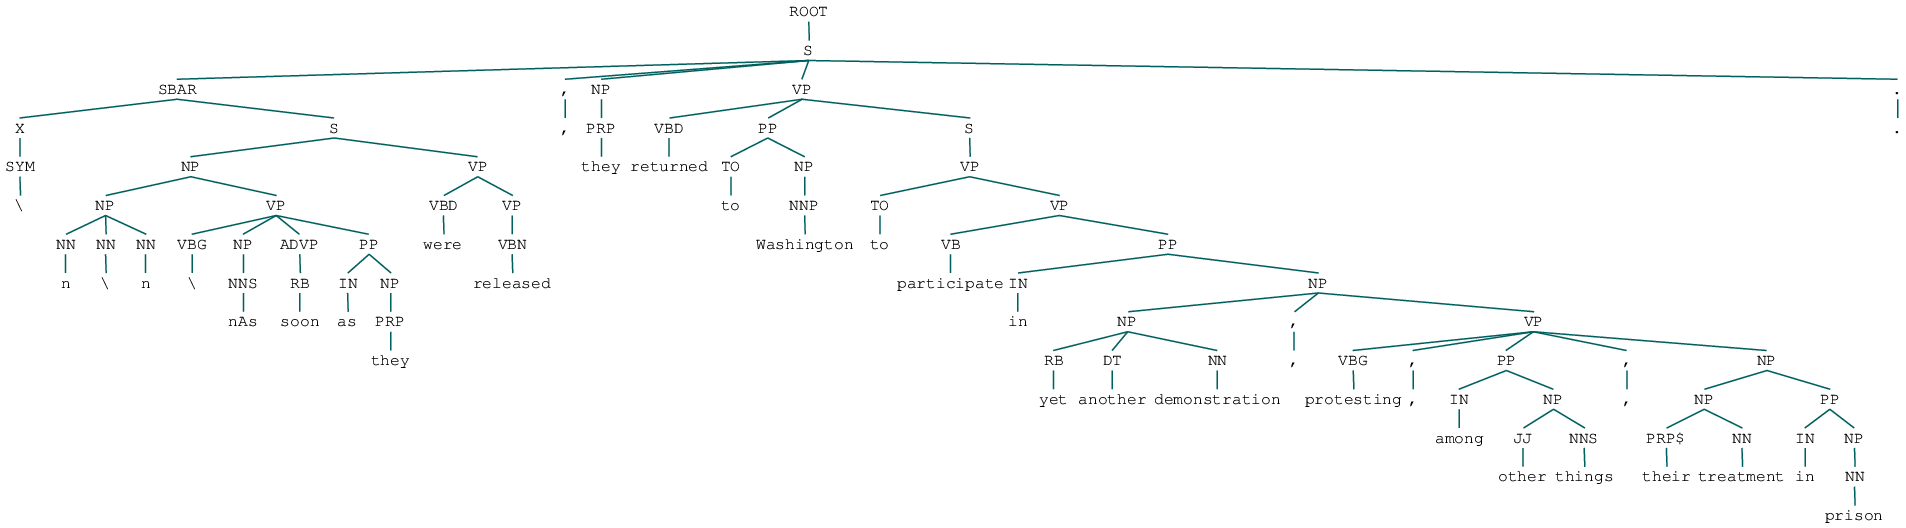

'Text = \\n\\n\\nAs soon as they were released, they returned to Washington to participate in  yet another demonstration, protesting, among other things, their treatment in prison.'

'Code = 141'

'AID = 22345754'

0

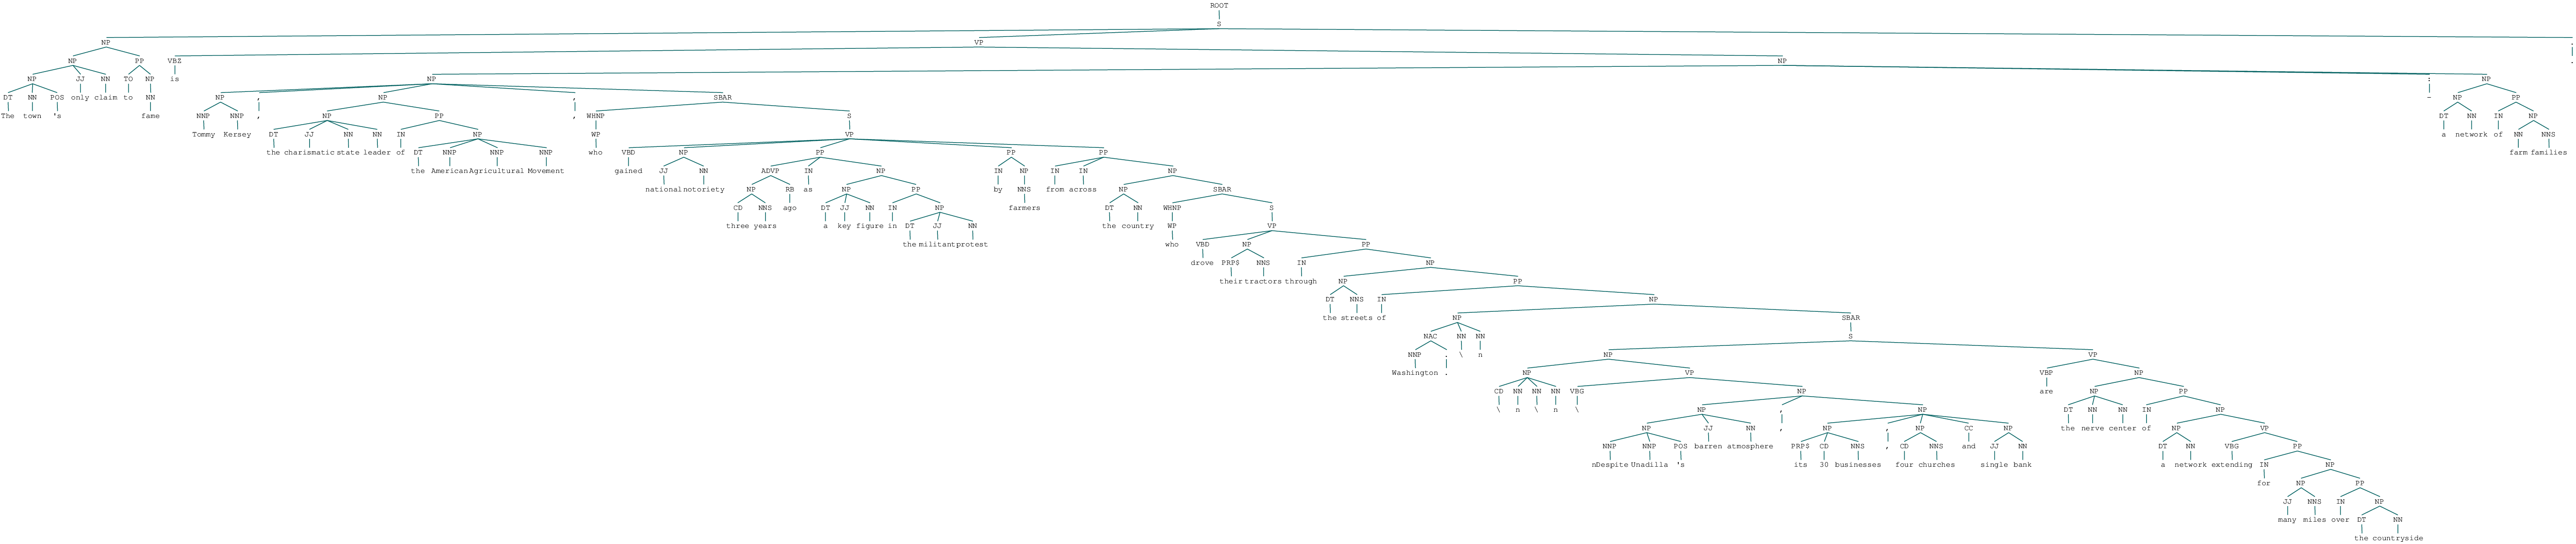

"Text = The town's only claim to fame is Tommy Kersey, the charismatic state leader of the American Agricultural Movement, who gained national notoriety three years ago as a key figure in the militant protest by farmers from across the country who drove their tractors through the streets of Washington.\\n\\n\\n\\nDespite Unadilla's barren atmosphere, its 30 businesses, four churches and single bank are the nerve center of a network extending for many miles over the countryside - a network of farm families."

'Code = 141'

'AID = 22388603'

1

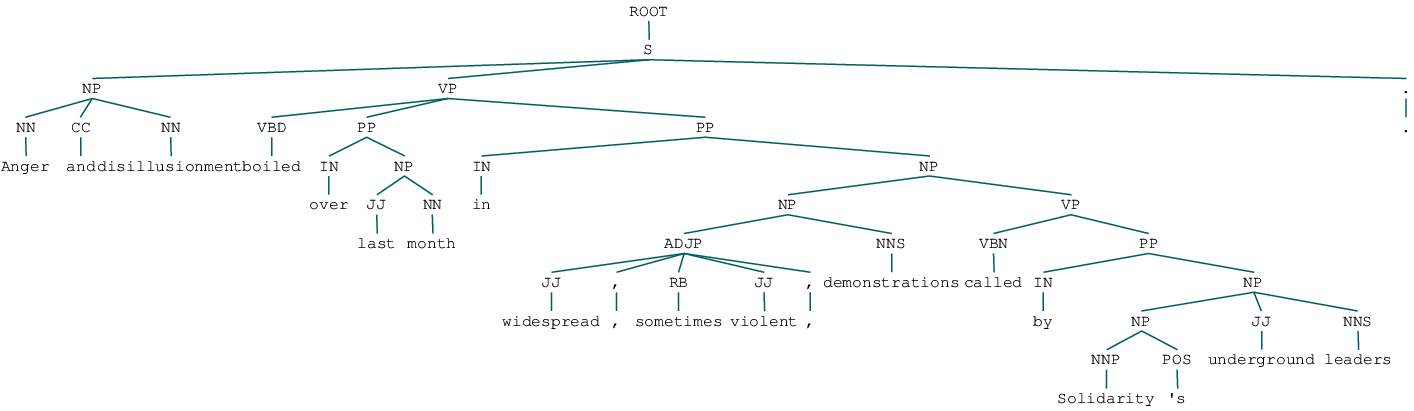

"Text = Anger and disillusionment boiled over last month in widespread, sometimes violent, demonstrations called by Solidarity's underground leaders."

'Code = 141'

'AID = 22482592'

2

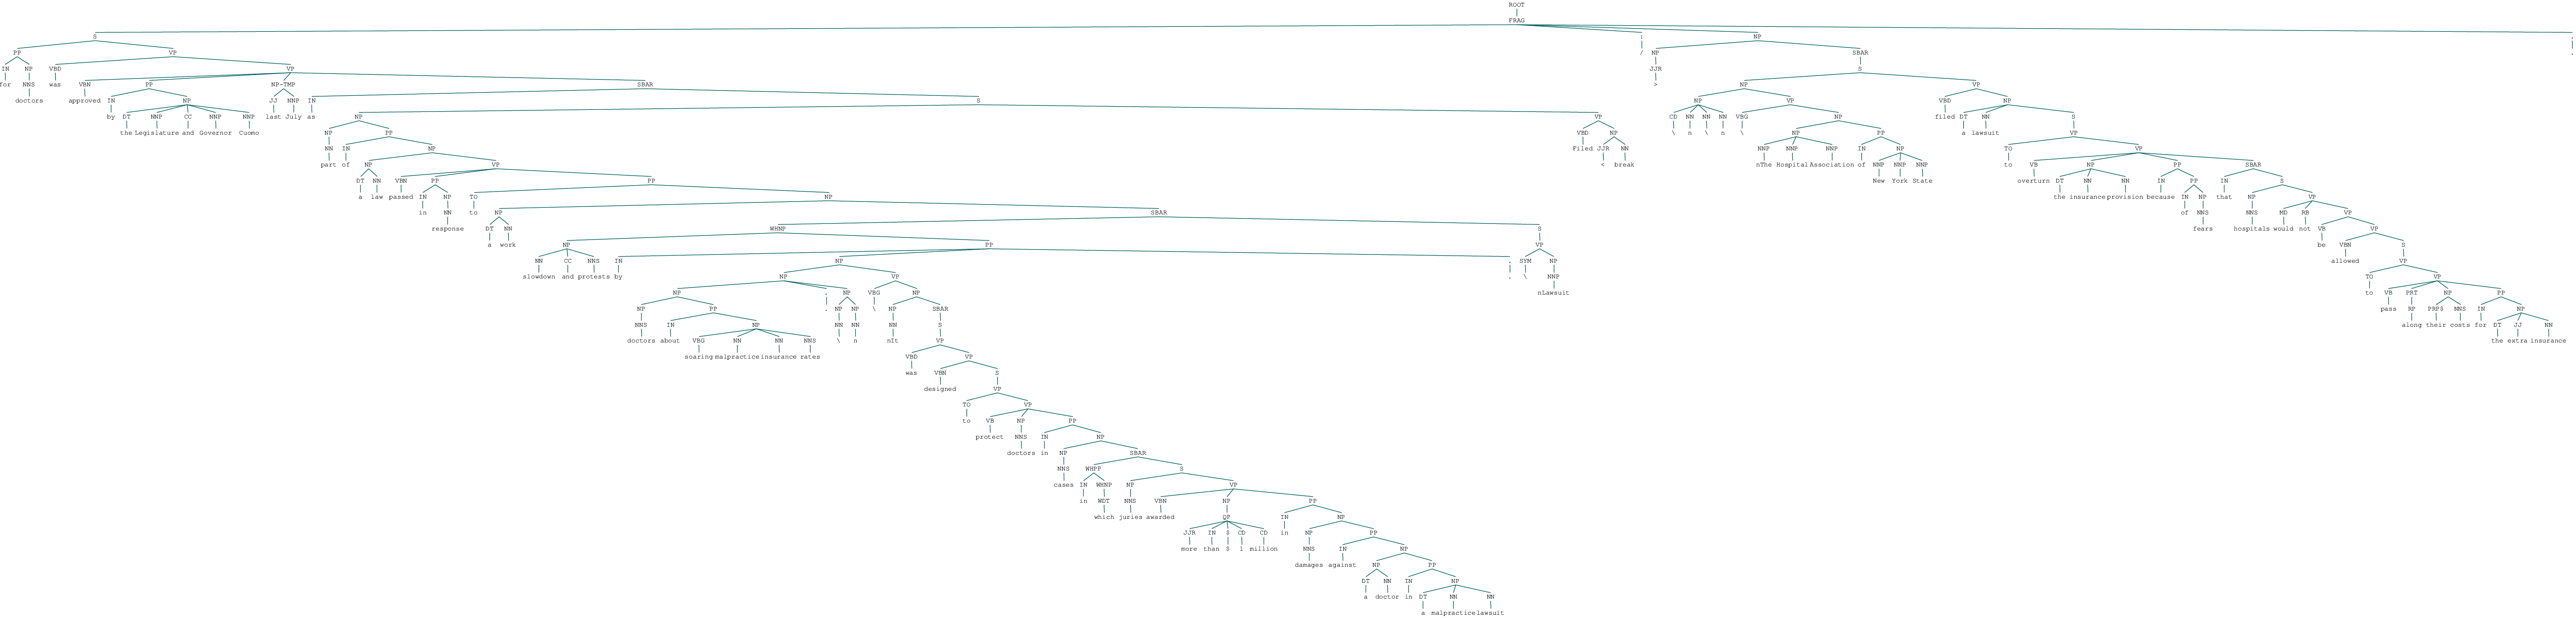

'Text = for doctors was approved by the Legislature and Governor Cuomo last July as part of a law passed in response to a work slowdown and protests by doctors about soaring malpractice insurance rates.\\n\\nIt was designed to protect doctors in cases in which juries awarded more than $1 million in damages against a doctor in a malpractice lawsuit.\\nLawsuit Filed &lt;break/&gt;\\n\\n\\nThe Hospital Association of New York State filed a lawsuit to overturn the insurance provision because of fears that hospitals would not be allowed to pass along their costs for the extra insurance.'

'Code = 141'

'AID = 22705150'

3

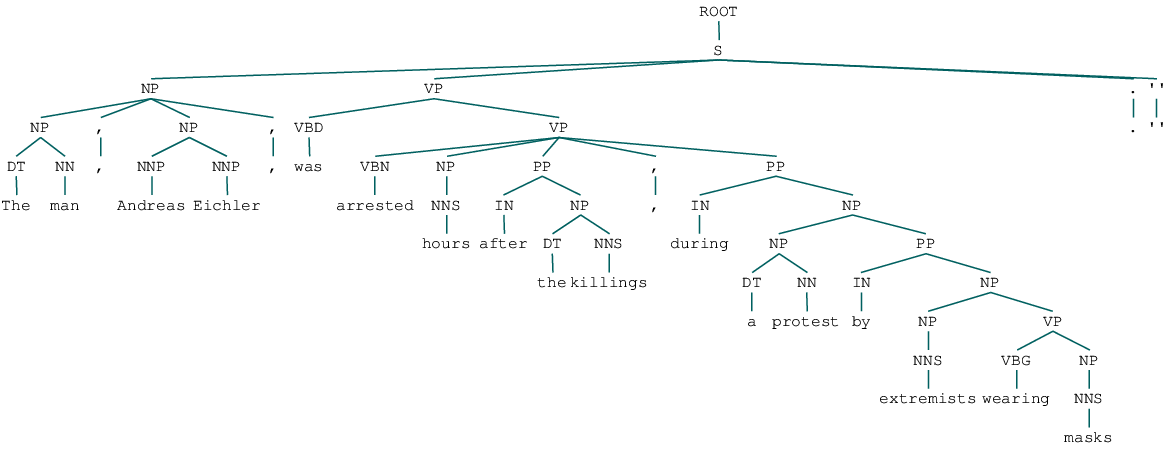

'Text = The man, Andreas Eichler, was arrested hours after the killings, during a protest by extremists wearing masks."'

'Code = 141'

'AID = 22834700'

4

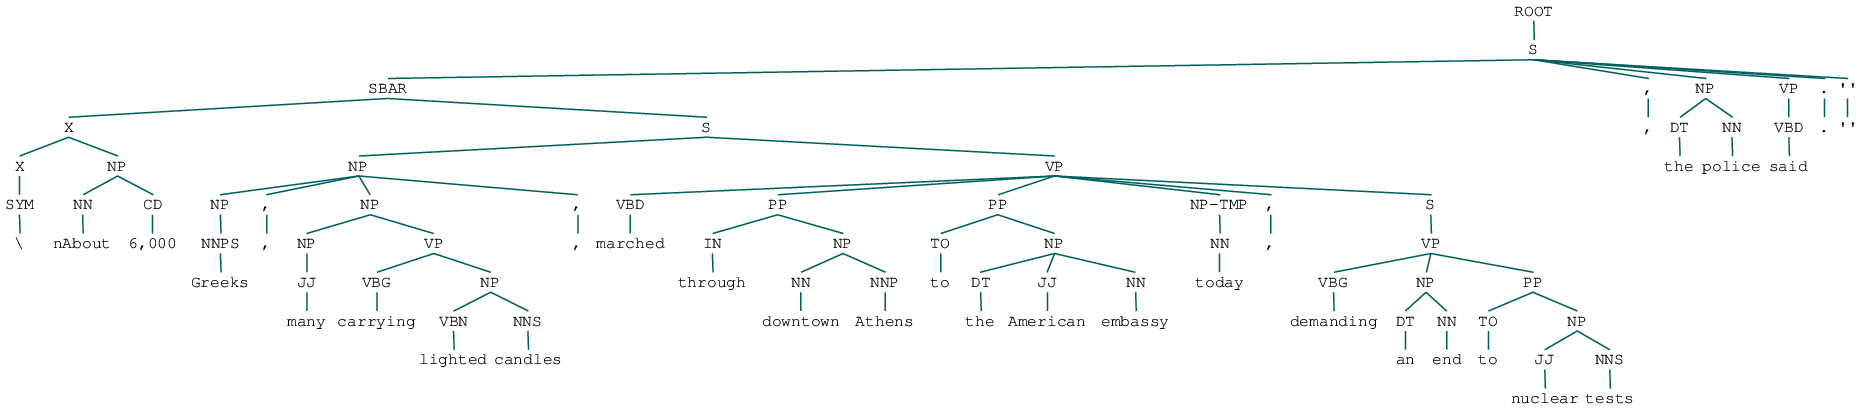

'Text = \\nAbout 6,000 Greeks, many carrying lighted candles, marched through downtown Athens to the American embassy today, demanding an end to nuclear tests, the police said."'

'Code = 141'

'AID = 22865986'

5

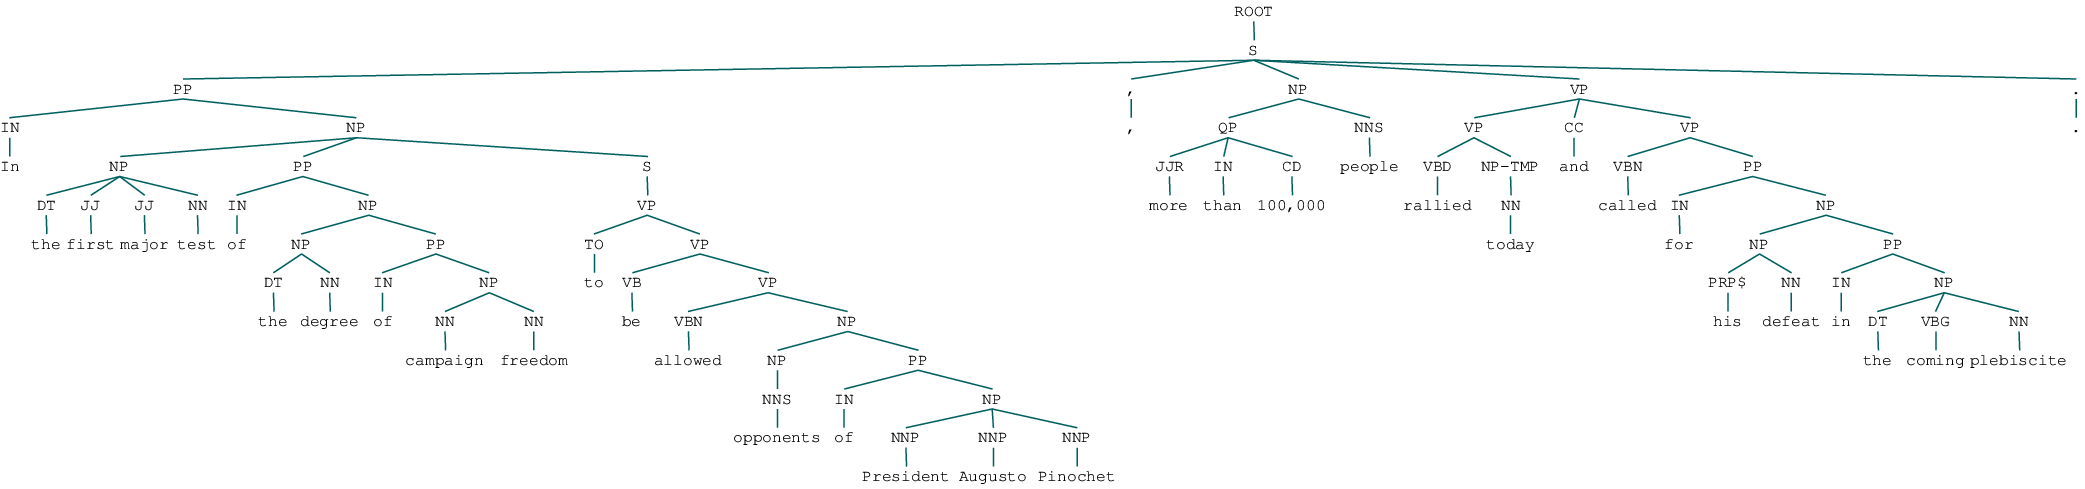

'Text = In the first major test of the degree of campaign freedom to be allowed opponents of President Augusto Pinochet, more than 100,000 people rallied today and called for his defeat in the coming plebiscite.'

'Code = 141'

'AID = 22885669'

6

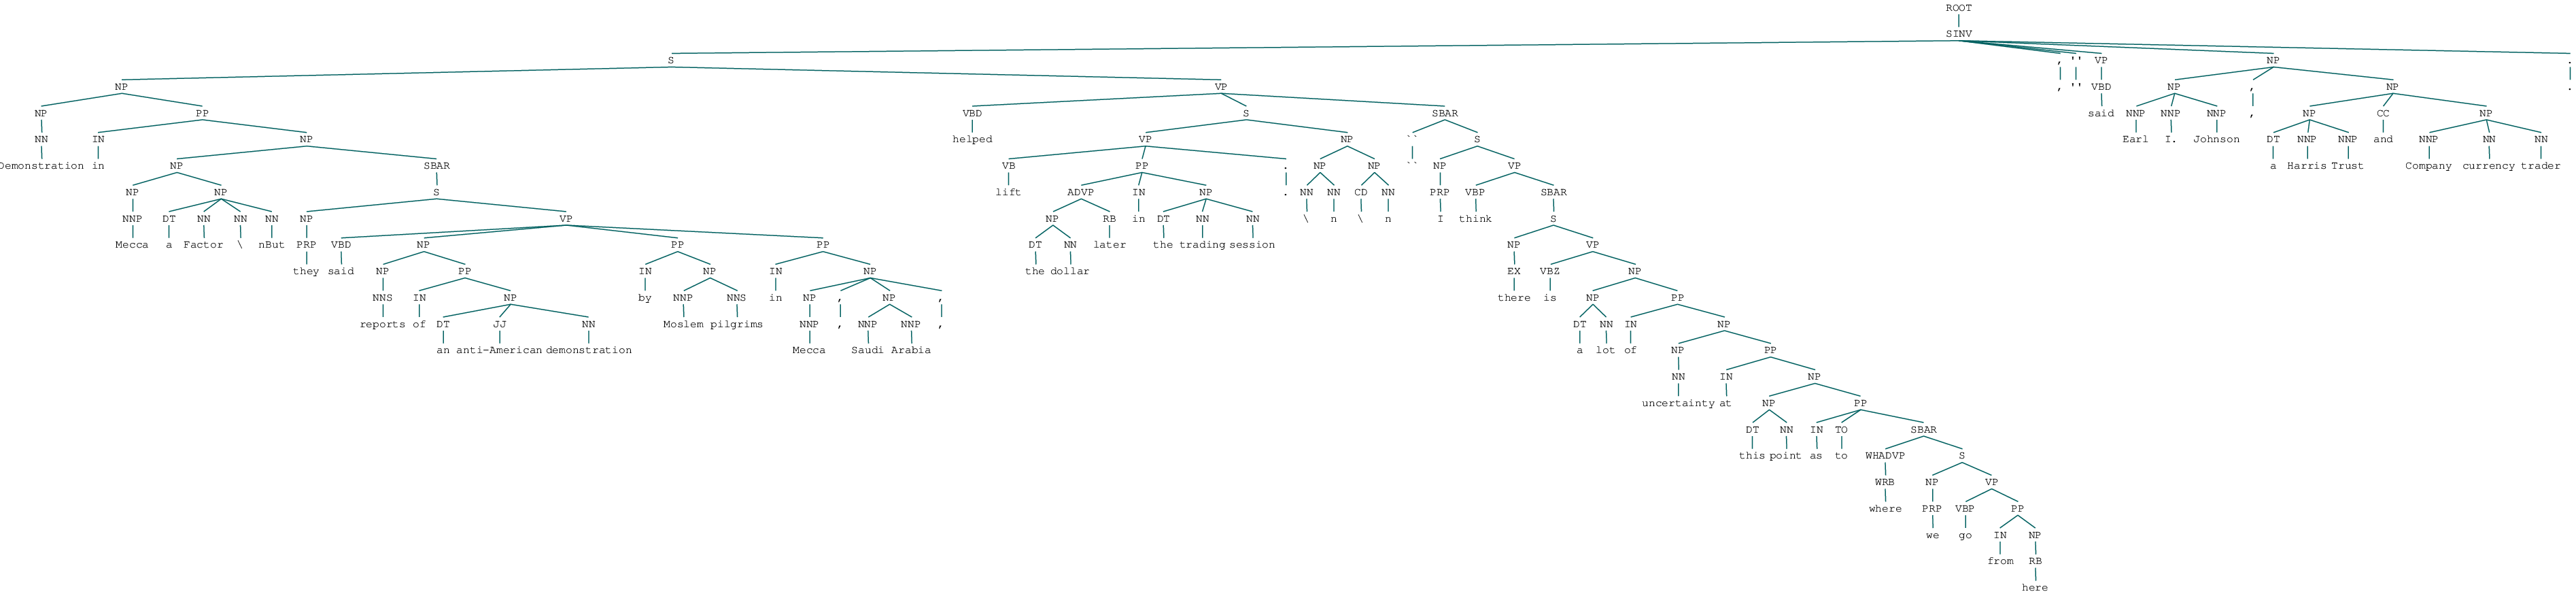

"Text = Demonstration in Mecca a Factor \\nBut they said reports of an anti-American demonstration by Moslem pilgrims in Mecca, Saudi Arabia, helped lift the dollar later in the trading session.\\n\\n''I think there is a lot of uncertainty at this point as to where we go from here,'' said Earl I. Johnson, a Harris Trust and Company currency trader."

'Code = 141'

'AID = 22914244'

7

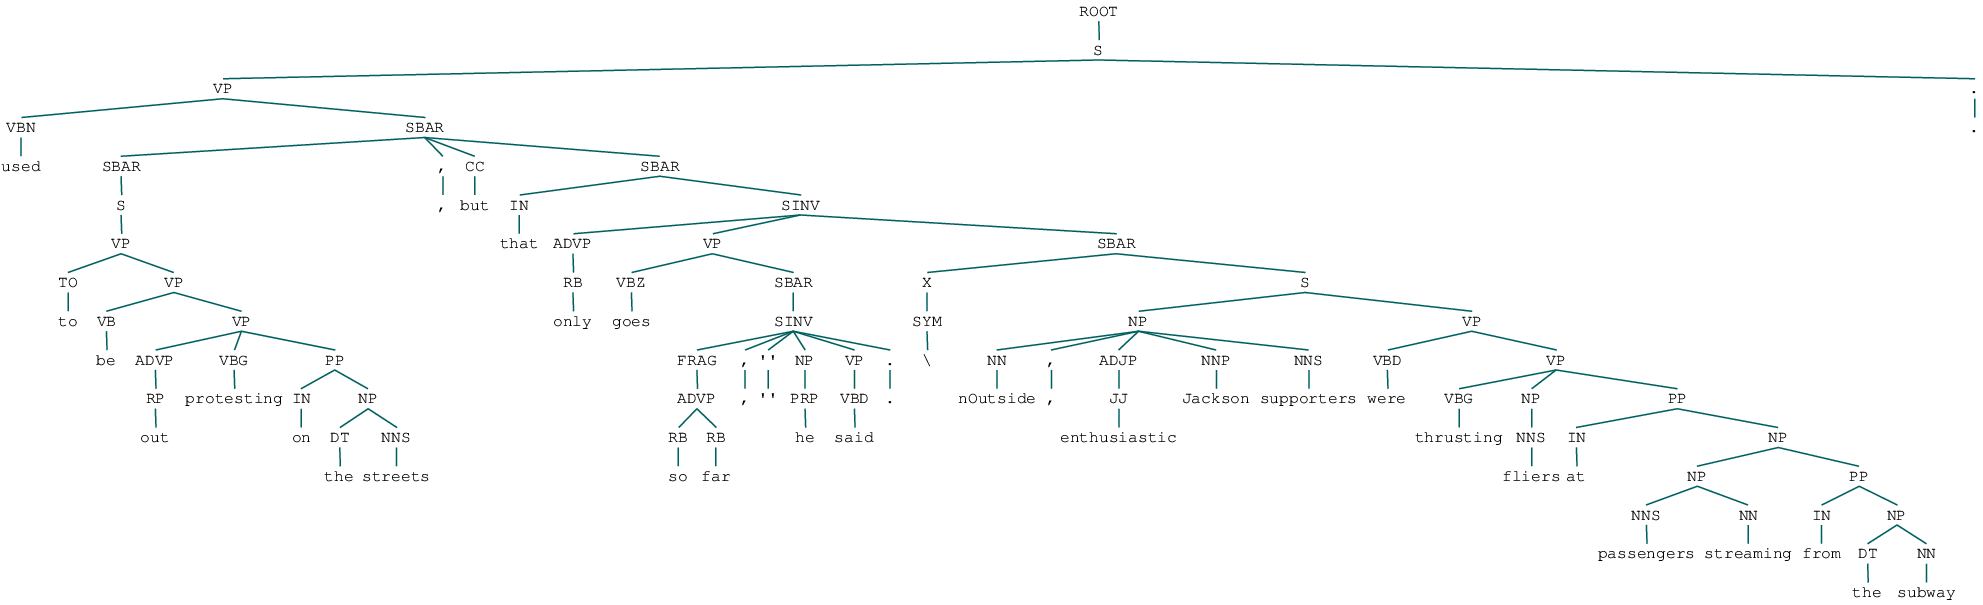

"Text = used to be out protesting on the streets, but that only goes so far,'' he said.\\nOutside, enthusiastic Jackson supporters were thrusting fliers at passengers streaming from the subway."

'Code = 141'

'AID = 22926655'

8

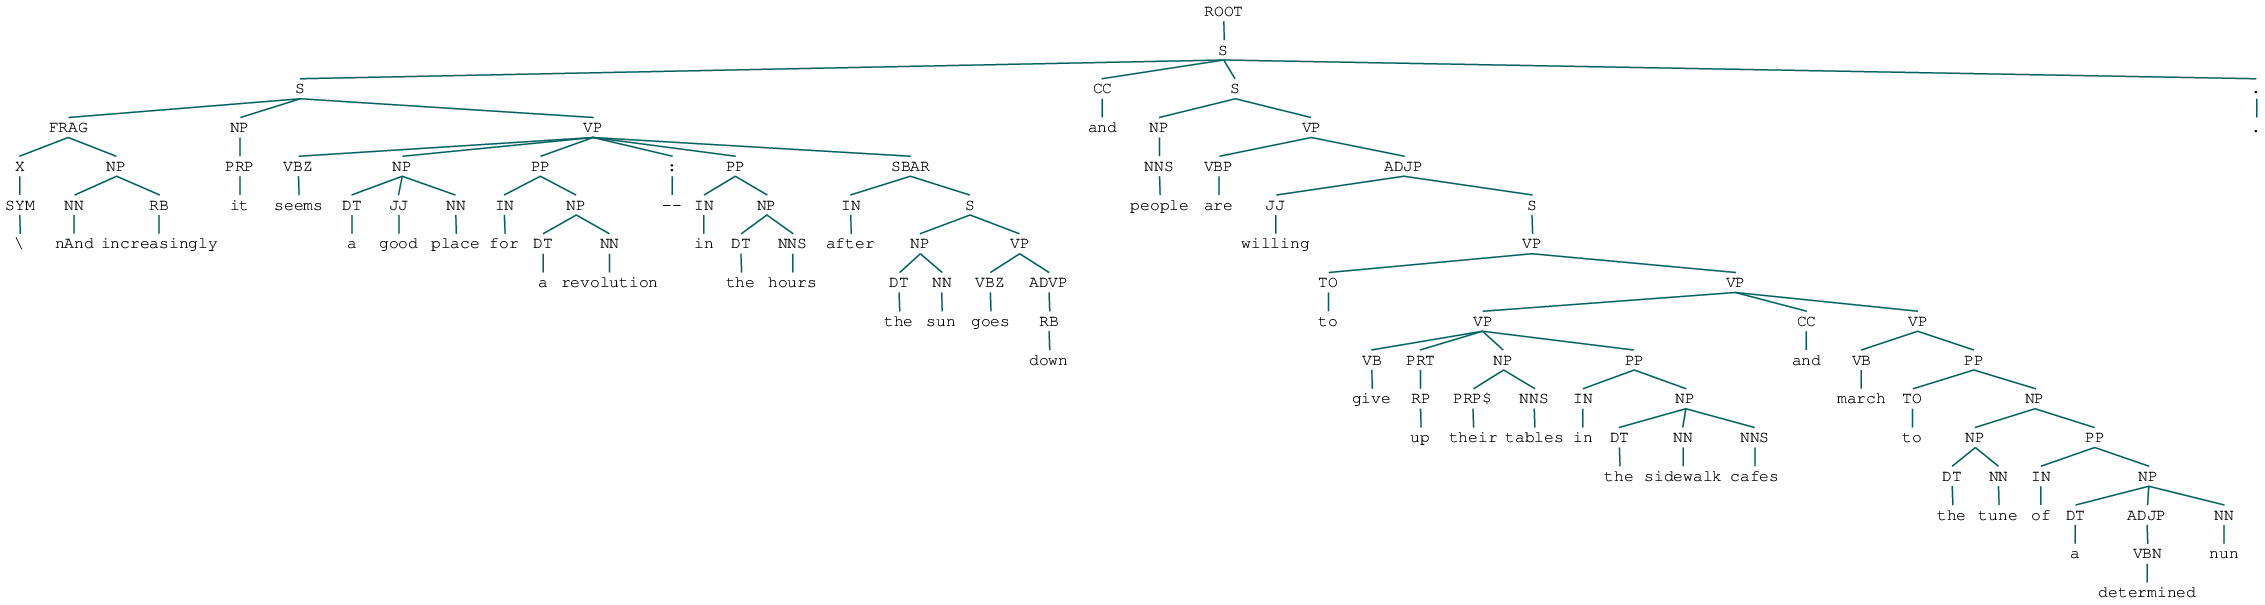

'Text = \\nAnd increasingly it seems a good place for a revolution -- in the hours after the sun goes down and people are willing to give up their tables in the sidewalk cafes and march to the tune of a determined nun.'

'Code = 141'

'AID = 23058691'

9

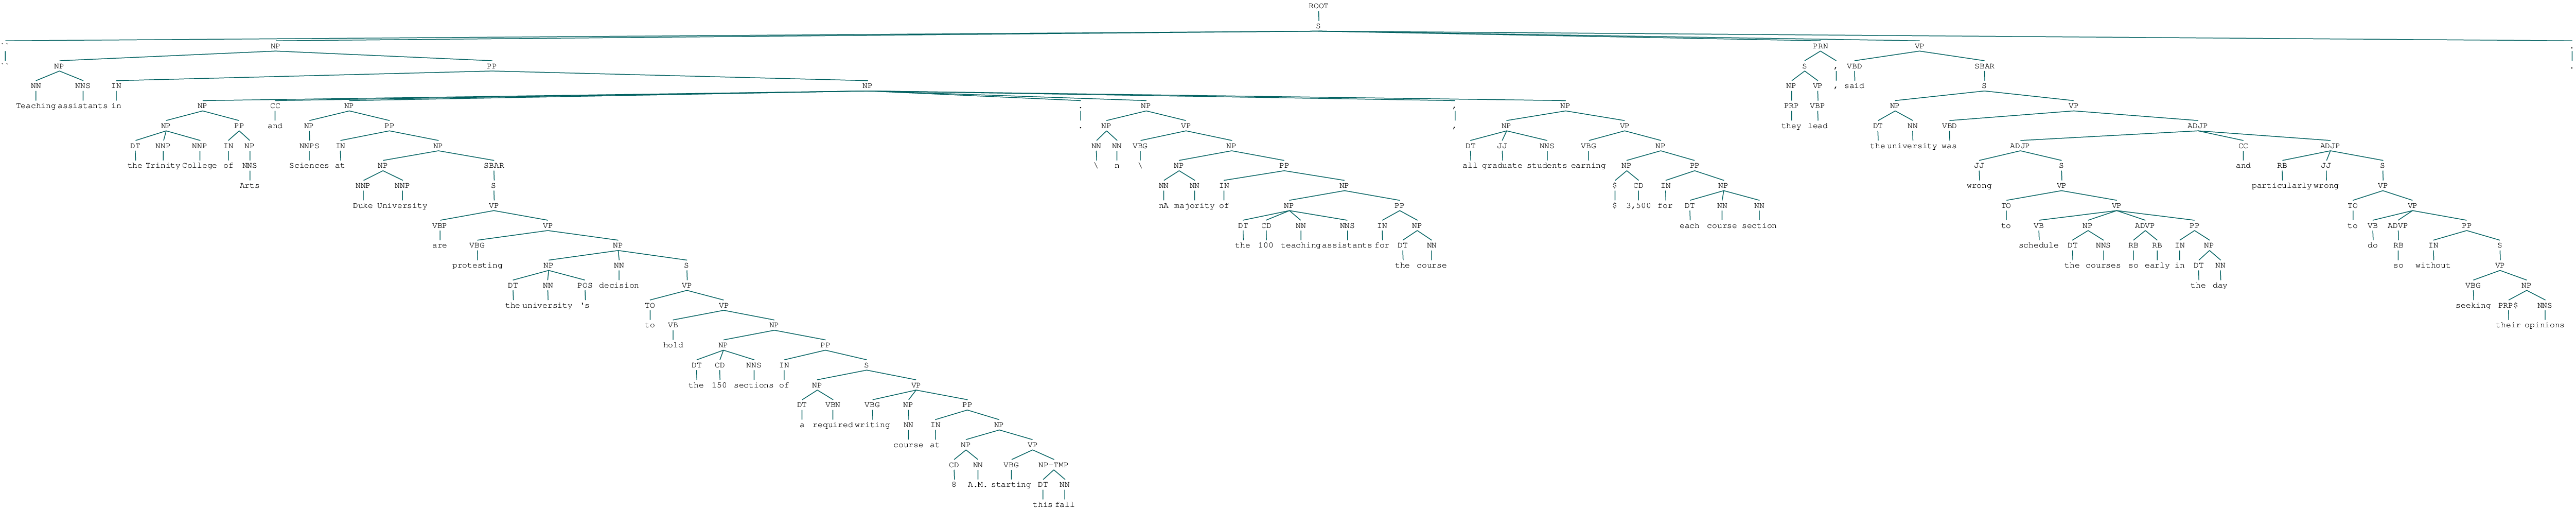

'Text = "Teaching assistants in the Trinity College of Arts and Sciences at Duke University are protesting the university\'s decision to hold the 150 sections of a required writing course at 8 A.M. starting this fall.\\n\\nA majority of the 100 teaching assistants for the course, all graduate students earning $3,500 for each course section they lead, said the university was wrong to schedule the courses so early in the day and particularly wrong to do so without seeking their opinions.'

'Code = 141'

'AID = 23186819'

10

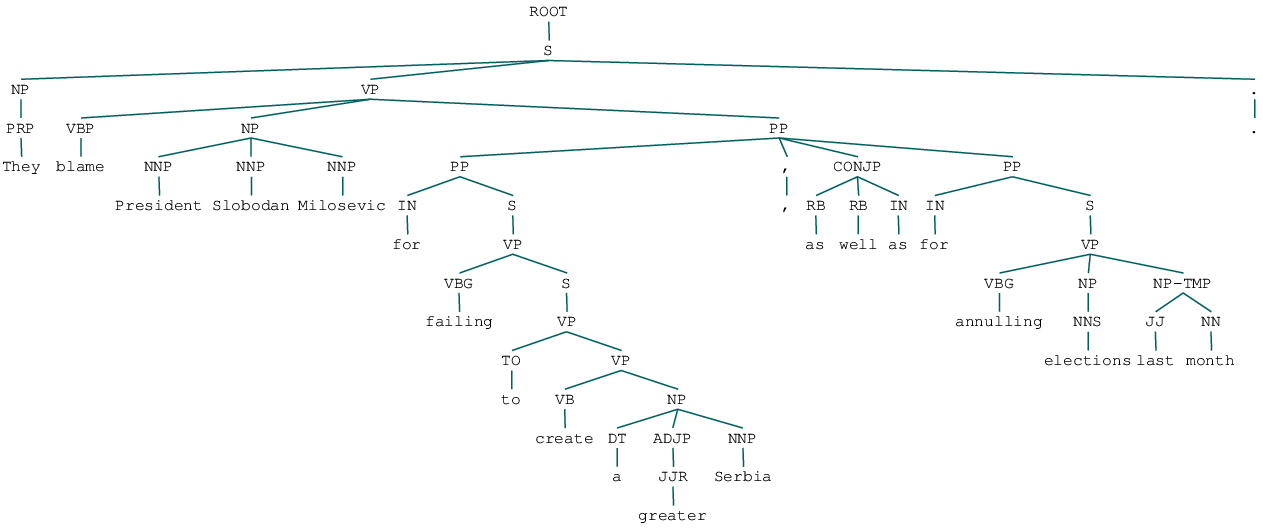

'Text = They blame President Slobodan Milosevic for failing to create a greater Serbia, as well as for annulling elections last month.'

'Code = 141'

'AID = 23488845'

11

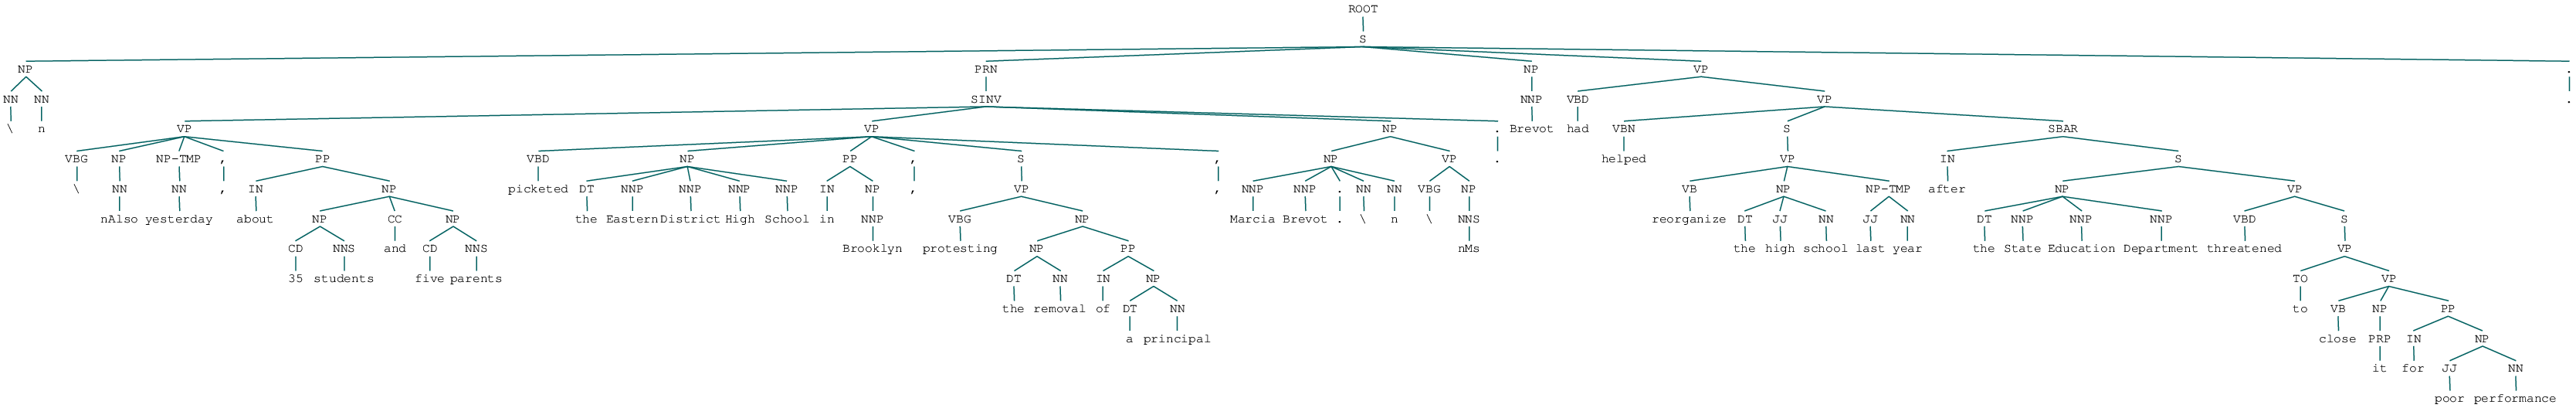

'Text = \\n\\nAlso yesterday, about 35 students and five parents picketed the Eastern District High School in Brooklyn, protesting the removal of a principal, Marcia Brevot.\\n\\nMs. Brevot had helped reorganize the high school last year after the State Education Department threatened to close it for poor performance.'

'Code = 141'

'AID = 23566672'

12

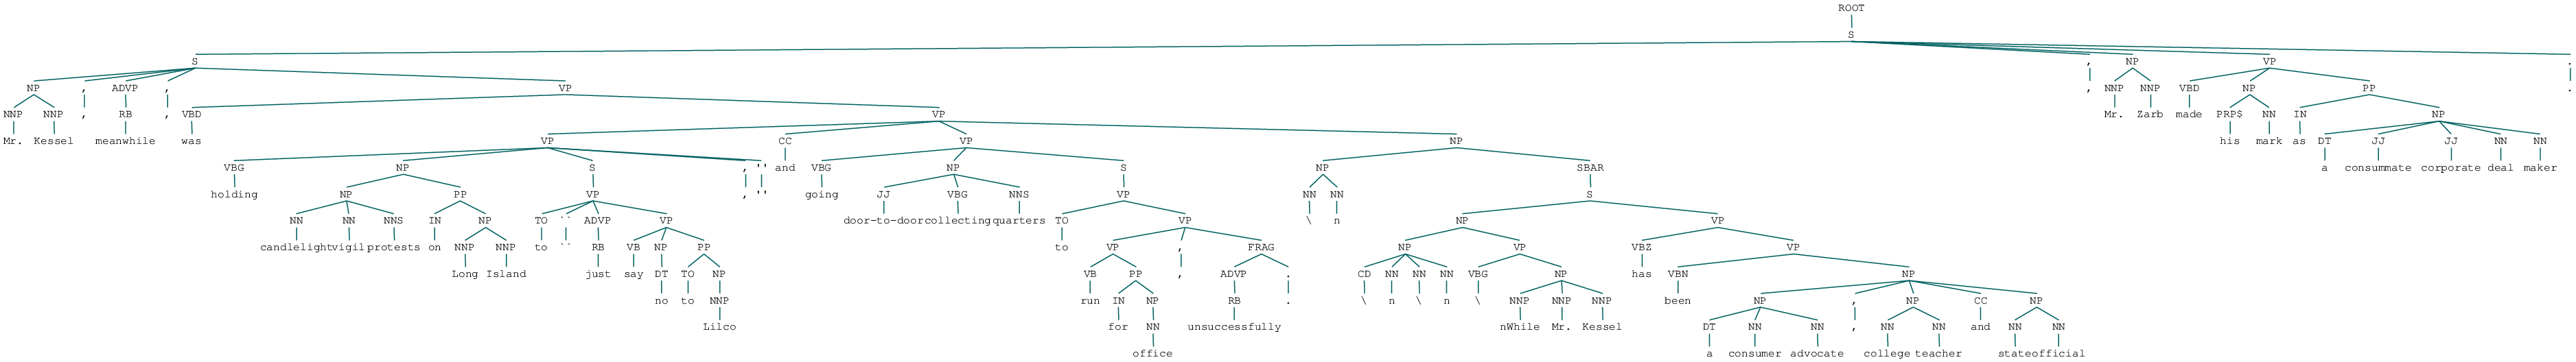

"Text = Mr. Kessel, meanwhile, was holding candlelight vigil protests on Long Island to ''just say no to Lilco,'' and going door-to-door collecting quarters to run for office, unsuccessfully.\\n\\n\\n\\nWhile Mr. Kessel has been a consumer advocate, college teacher and state official, Mr. Zarb made his mark as a consummate corporate deal maker."

'Code = 141'

'AID = 23572395'

13

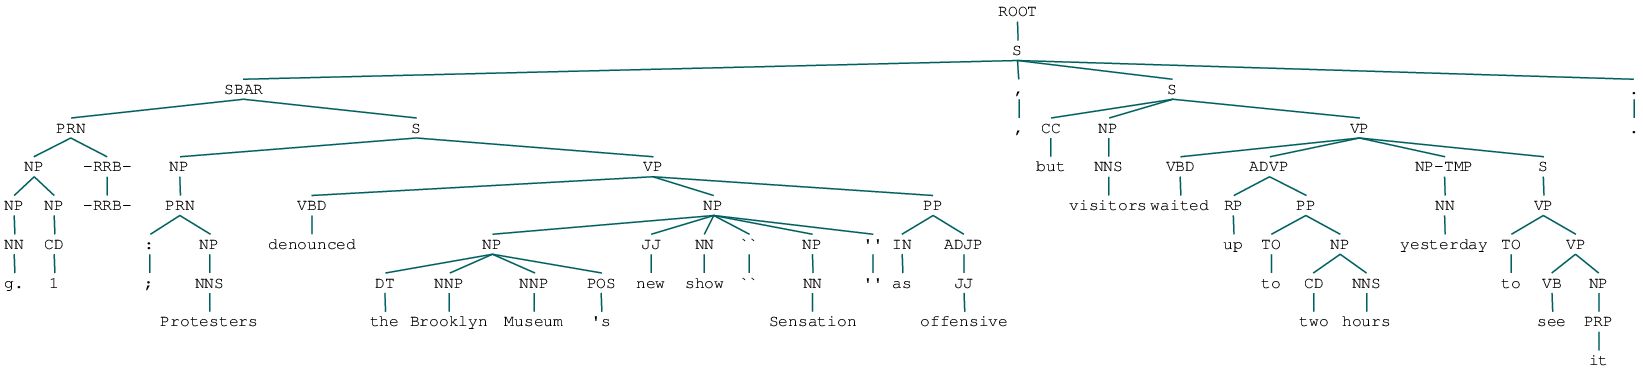

"Text = g. 1); Protesters denounced the Brooklyn Museum's new show ''Sensation'' as offensive, but visitors waited up to two hours yesterday to see it."

'Code = 141'

'AID = 23677005'

14

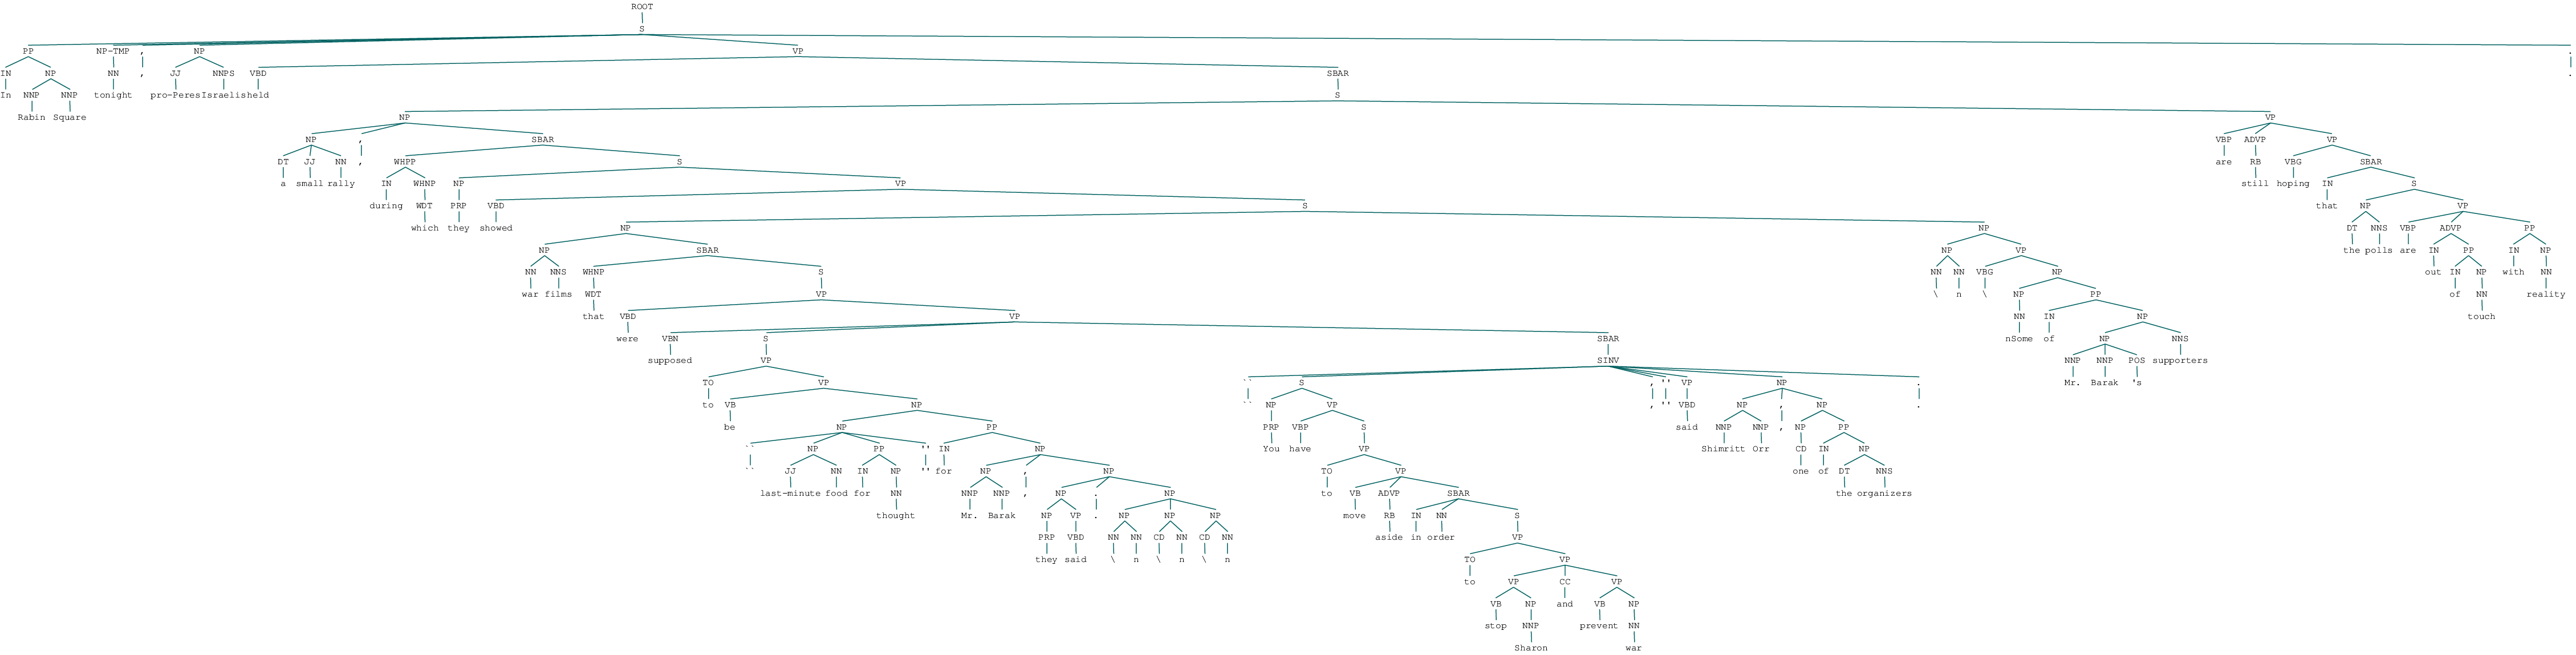

"Text = In Rabin Square tonight, pro-Peres Israelis held a small rally, during which they showed war films that were supposed to be ''last-minute food for thought'' for Mr. Barak, they said.\\n\\n\\n''You have to move aside in order to stop Sharon and prevent war,'' said Shimritt Orr, one of the organizers.\\n\\nSome of Mr. Barak's supporters are still hoping that the polls are out of touch with reality."

'Code = 141'

'AID = 23778615'

15

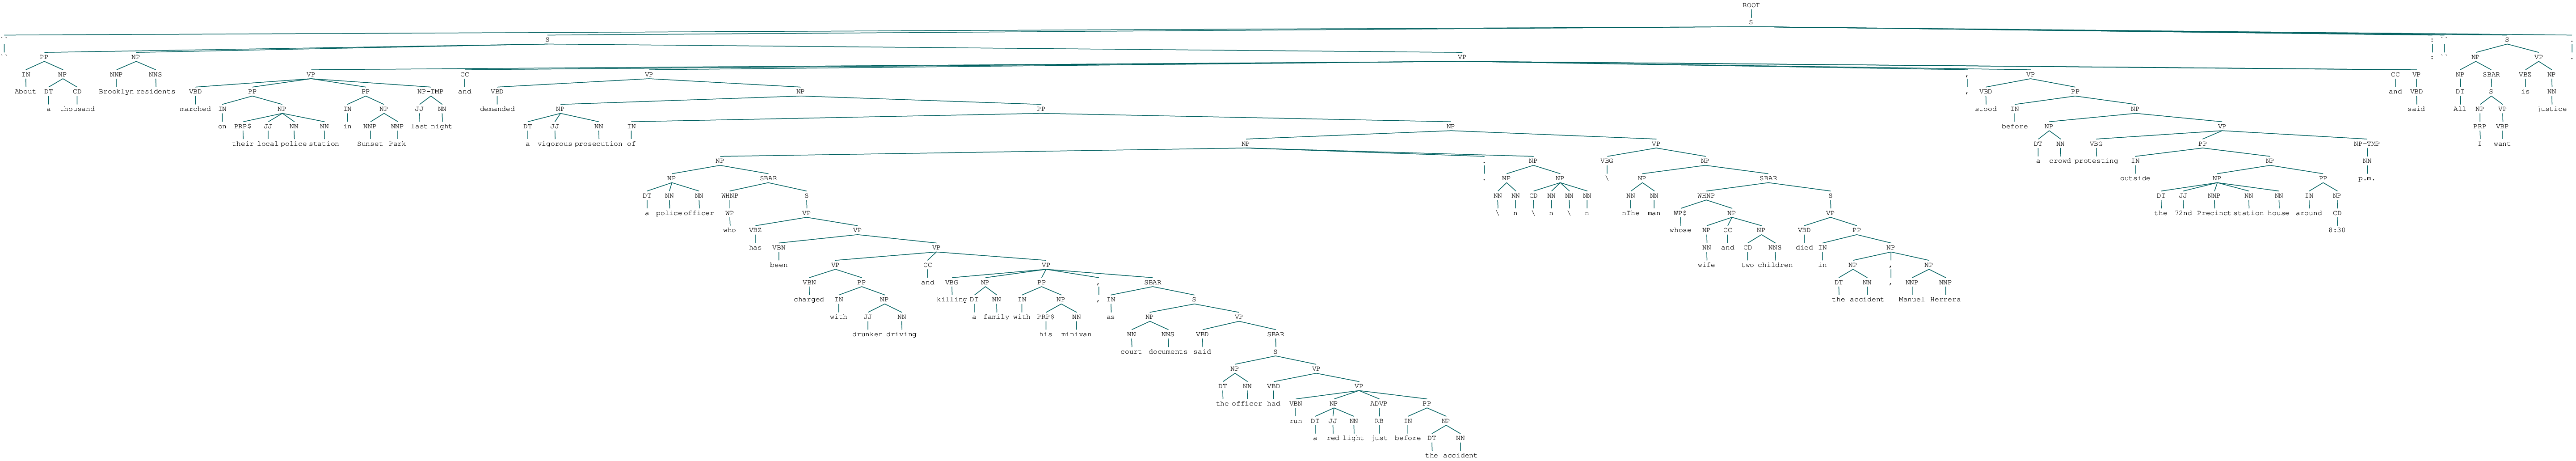

'Text = "About a thousand Brooklyn residents marched on their local police station in Sunset Park last night and demanded a vigorous prosecution of a police officer who has been charged with drunken driving and killing a family with his minivan, as court documents said the officer had run a red light just before the accident.\\n\\n\\n\\nThe man whose wife and two children died in the accident, Manuel Herrera, stood before a crowd protesting outside the 72nd Precinct station house around 8:30 p.m. and said: \'\'All I want is justice.'

'Code = 141'

'AID = 23785120'

16

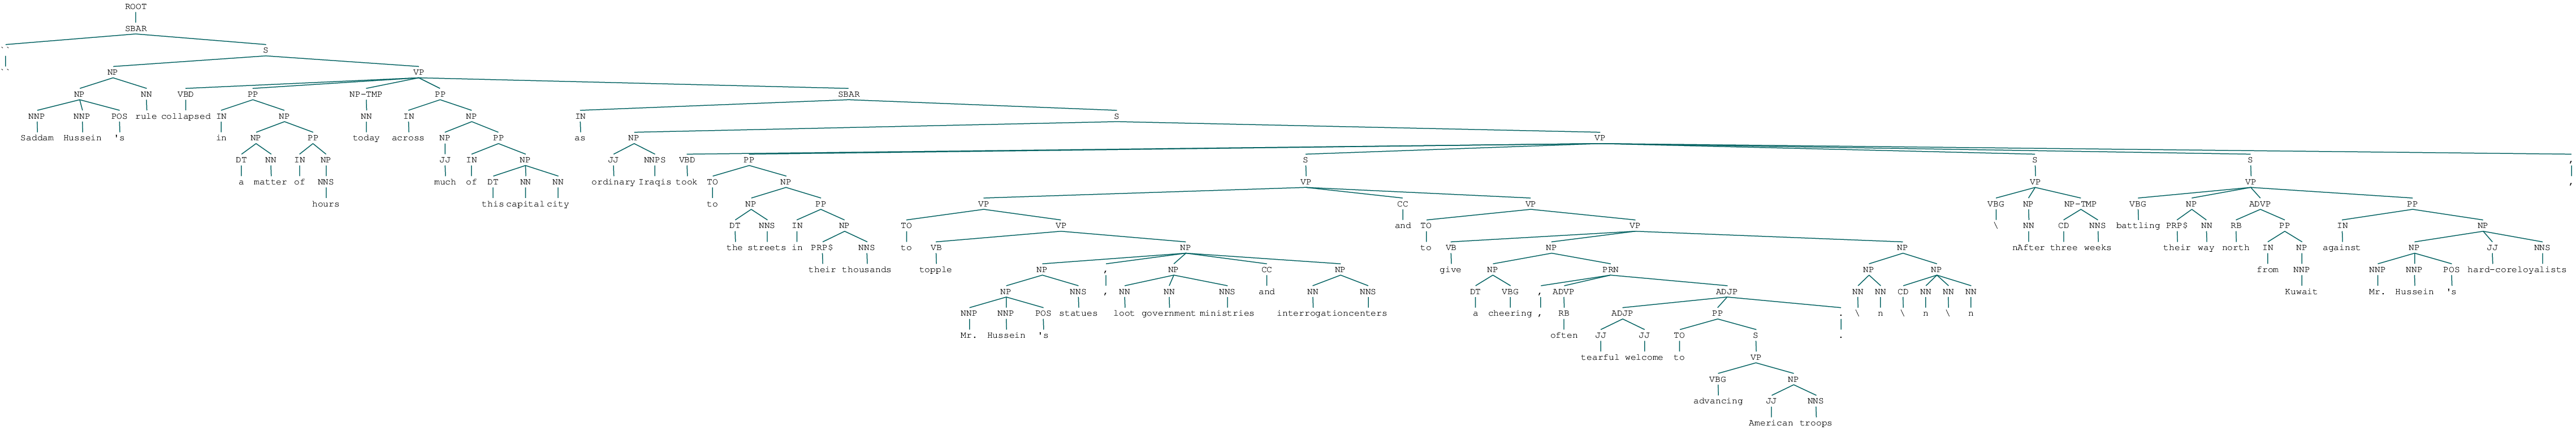

'Text = "Saddam Hussein\'s rule collapsed in a matter of hours today across much of this capital city as ordinary Iraqis took to the streets in their thousands to topple Mr. Hussein\'s statues, loot government ministries and interrogation centers and to give a cheering, often tearful welcome to advancing American troops.\\n\\n\\n\\nAfter three weeks battling their way north from Kuwait against Mr. Hussein\'s hard-core loyalists,'

'Code = 141'

'AID = 23951459'

17

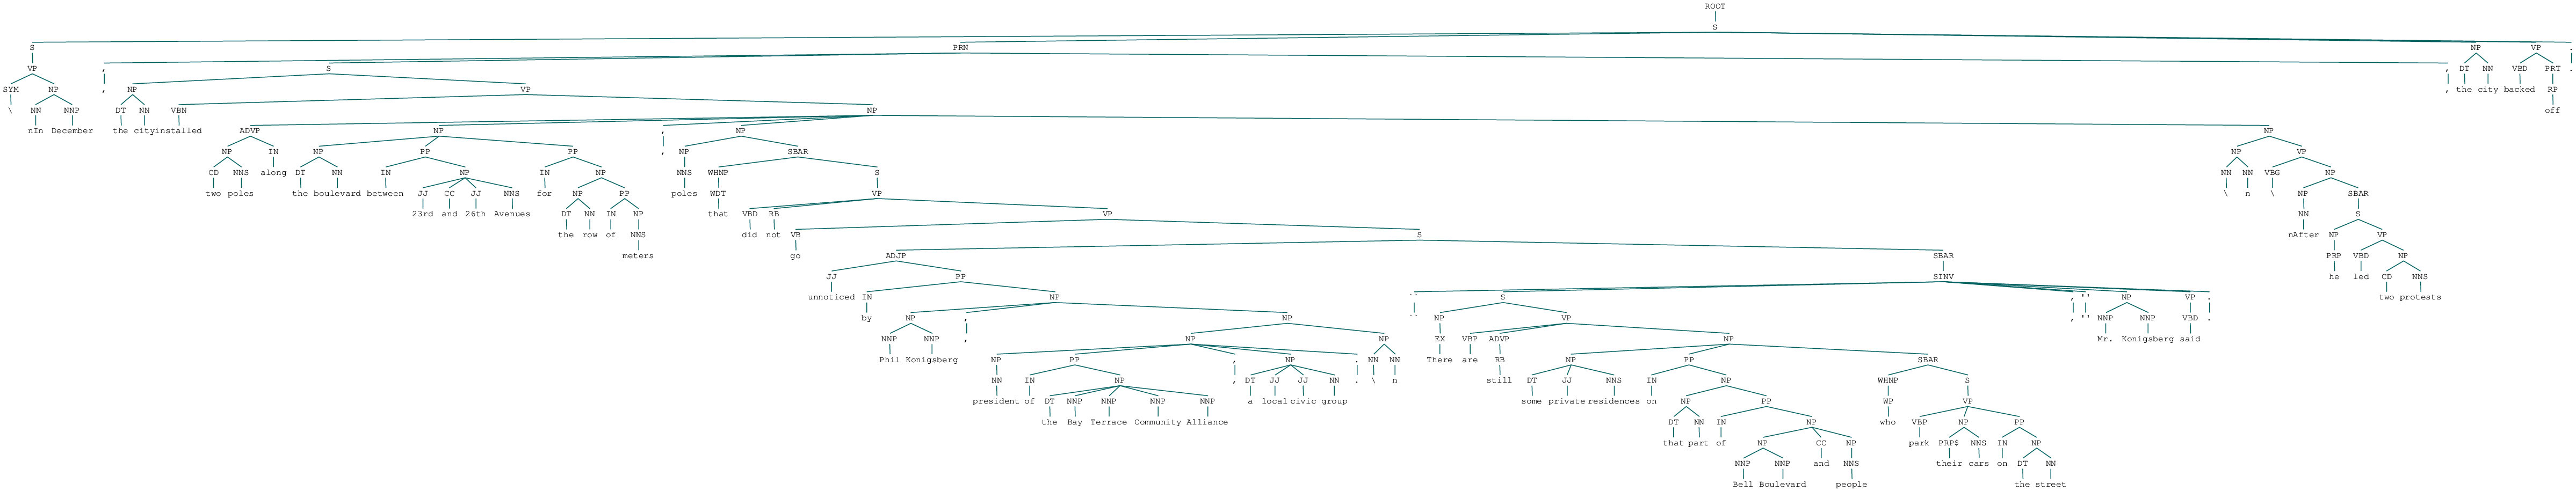

"Text = \\nIn December, the city installed two poles along the boulevard between 23rd and 26th Avenues for the row of meters, poles that did not go unnoticed by Phil Konigsberg, president of the Bay Terrace Community Alliance, a local civic group.\\n''There are still some private residences on that part of Bell Boulevard and people who park their cars on the street,'' Mr. Konigsberg said.\\n\\nAfter he led two protests, the city backed off."

'Code = 141'

'AID = 23977328'

18

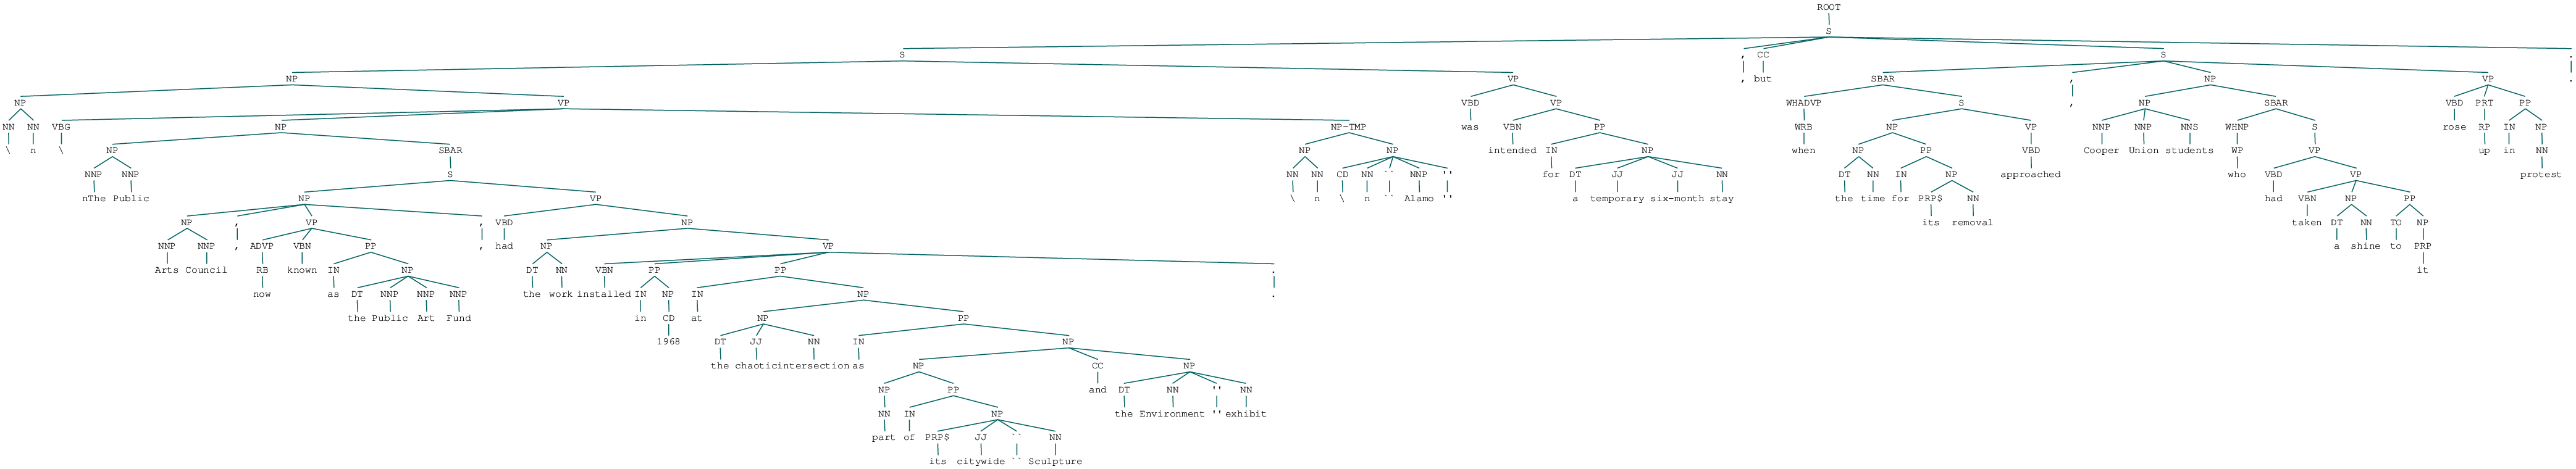

"Text = \\n\\nThe Public Arts Council, now known as the Public Art Fund, had the work installed in 1968 at the chaotic intersection as part of its citywide ''Sculpture and the Environment'' exhibit.\\n\\n''Alamo'' was intended for a temporary six-month stay, but when the time for its removal approached, Cooper Union students who had taken a shine to it rose up in protest."

'Code = 141'

'AID = 24029328'

19

In [82]:
for i in range(len(accent4_141)):
    parsed_output(accent4_141, i)
    display(i)

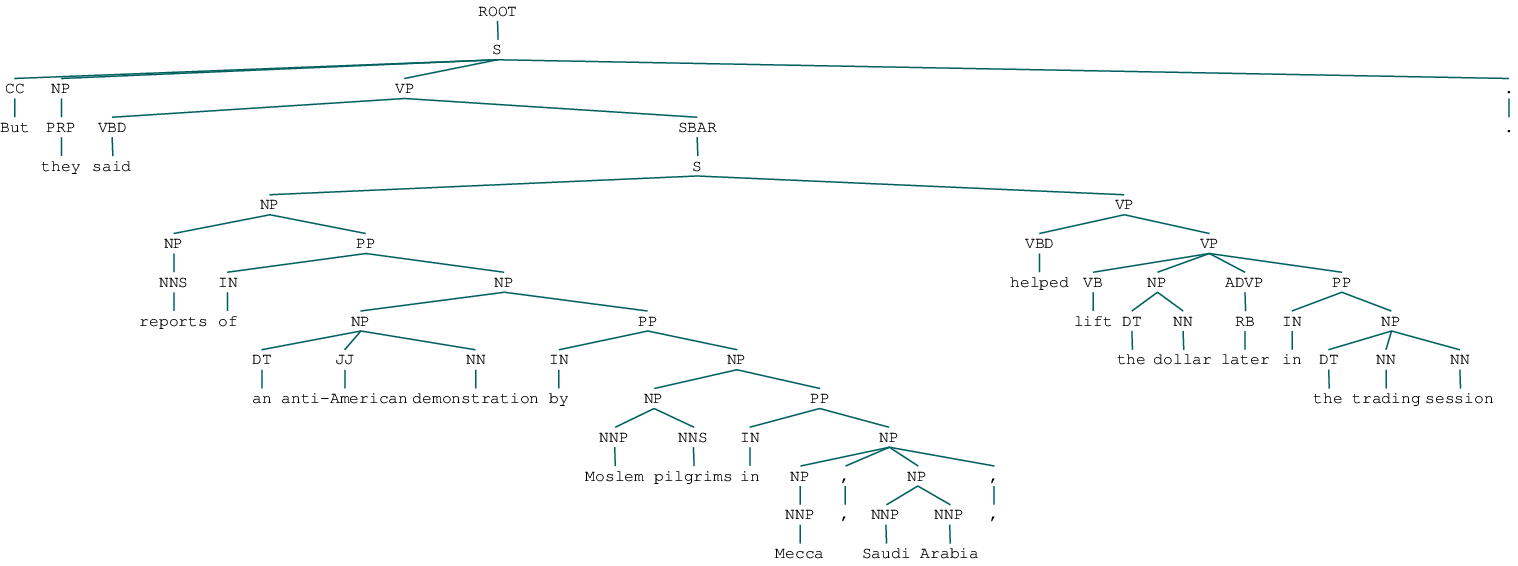

In [86]:
one_sentence_parser("But they said reports of an anti-American demonstration by Moslem pilgrims in Mecca, Saudi Arabia, helped lift the dollar later in the trading session.")